In [1]:
import numpy as np 
from numpy.linalg import qr, svd
from scipy.linalg import hadamard, subspace_angles

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.colors as colors

import imageio
import datetime

from linear_sca import *



In [2]:
X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/churchland.npy') 
d = 3

X, _ = pre_processing(X_init, center=False, pca=False, soft_normalize='max')
X = jnp.array(X)
K, N, T = X.shape
A = jnp.swapaxes(pre_processing(X_init, pca=False, soft_normalize='max')[0], 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

def K_X_Y_diagonal(X, Y, sigma_sqrd):
    """For two spatial patterns X and Y, the kernel k(x_i,y_i) is equal to sum_i sigma_i^2 x_i y_i"""
    return jnp.dot(X.T * sigma_sqrd, Y) 

def K_X_Y_identity(X, Y):
    return jnp.dot(X.T, Y) 

K_A_X = K_X_Y_identity(A, X)                                    #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [19]:
#np.save('P', P)
#np.save('S', S)

#S = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/30_5_2024/pca_uncentered_churchland/S.npy")
#P = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/30_5_2024/pca_uncentered_churchland/P.npy")

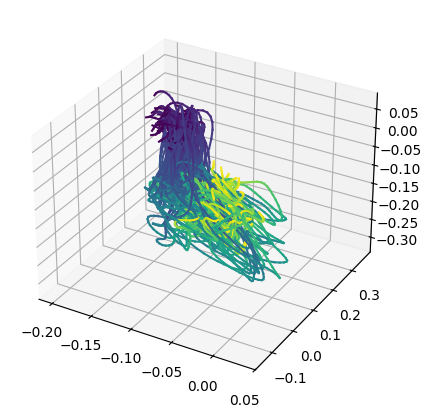

In [36]:
alpha_tilde = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/outputs_cluster/outputs/a_revised_pca_false_softnorm_max.npy")

alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
#alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * alpha_tilde_QR
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_3D(projection)

In [41]:
U = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/optimized_U_linear_SCA/U_churchland_0.001_10000_3d.npy')
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, pre_processing(X_init, soft_normalize='max')[0])

Q_Y, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
Q_projection, _ = qr(projection.swapaxes(1,2).reshape(-1,d))
np.rad2deg(subspace_angles(Q_Y, Q_projection))[-1]


80.07225

In [24]:
fig = go.Figure()
num_time_points = projection.shape[-1]
indices_to_plot = np.arange(0,projection.shape[0],1)

for i in indices_to_plot:
    x = projection[i, 0, :]
    y = projection[i, 1, :]
    z = projection[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))
fig.show()
